In [1]:
# ============================================================
# Two-reaction, five-zone jacketed PFR (plug flow, no dispersion)
# Outlet regulation of c_B(L,t) or c_C(L,t) to a constant setpoint
# MVs: inlet flow F(t) and 5 jacket zone temperatures Tj_i(t)
# No move/effort penalties in the objective (pure regulation).
# Time units: hours (h), length: meters (m), temperature: K
# ============================================================

from pyomo.environ import *
import numpy as np
import math

# # -----------------------
# # Discretization settings
# # -----------------------
# N  = 50          # spatial nodes (incl. 0 and L)
# K  = 20           # time steps (0..K)
# L  = 20.0         # reactor length [m]
# dt = 0.02         # time step [h]  (0.02 h = 72 s)  -> total horizon ~ K*dt
# dz = L/(N-1)

# -----------------------
# Discretization settings
# -----------------------
N  = 10          # spatial nodes (incl. 0 and L)
K  = 10           # time steps (0..K)
L  = 20.0         # reactor length [m]
dt = 0.02         # time step [h]  (0.02 h = 72 s)  -> total horizon ~ K*dt
dz = L/(N-1)

# -----------------------
# Geometry & operation
# -----------------------
D_tube = 0.126                      # diameter [m]
A_t    = math.pi*(D_tube/2.0)**2    # cross-sectional area [m^2]

# Inlet conditions (fixed)
cA_in = 80.0     # mol/m^3
cB_in = 0.0
cC_in = 0.0
T_in  = 423.0    # K

# -----------------------
# Kinetics (from paper)
# -----------------------
Rgas  = 8.314          # J/mol/K
k01   = 0.1            # 1/h
E1    = 33475.0        # J/mol   (33.475 kJ/mol)
k02   = 9.0e-7         # m^3/(mol*h)
E2    = 75319.0        # J/mol   (75.319 kJ/mol)

# Heats of reaction (exothermic)
dH1   = -20.0e3        # J/mol
dH2   = -60.0e3        # J/mol

# Heat transfer (per volume)
Ua    = 8524.0 * 1e3         # J/(m^3*h*K)

# Effective volumetric heat capacity
# Paper gives molar cp ≈ 10 kJ/mol/K; with ~80 mol/m^3 feed, rhoCp_vol ≈ 8e5 J/m^3/K
rhoCp = 8.0e5          # J/(m^3*K)

# -----------------------
# Manifold: 5 jacket zones along z
# -----------------------
n_zones = 5
zone_bounds = np.linspace(0.0, L, n_zones+1)  # 0, L/5, 2L/5, ..., L

def zone_of_z(z):
    # return 1..5 for z in each segment (rightmost inclusive)
    for zi in range(n_zones):
        if (z >= zone_bounds[zi]) and (z <= zone_bounds[zi+1] + 1e-12):
            return zi+1
    return n_zones

# Map each spatial node to its zone (1..5)
z_nodes = np.array([i*dz for i in range(N)])
node_zone = {i: zone_of_z(z_nodes[i]) for i in range(N)}

# -----------------------
# MV bounds
# -----------------------
F_min, F_max = 0.6, 4.5           # volumetric flow [m^3/h] (strictly >0 for upwind)
Tj_min, Tj_max = 298.0, 600.0     # jacket temperature bounds [K]

# -----------------------
# CV target (choose 'B' or 'C')
# -----------------------
target_species = 'B'   # 'B' or 'C'
s = 40.0               # outlet setpoint [mol/m^3] (example; pick a feasible target)

# -----------------------
# Path/safety bounds
# -----------------------
T_lo, T_hi = 280.0, 700.0   # enforce T <= 700 K via var bounds

# ============================================================
# Pyomo model
# ============================================================
m = ConcreteModel()

m.I = RangeSet(0, N-1)   # space nodes
m.K = RangeSet(0, K)     # time nodes
m.Z = RangeSet(1, n_zones)

# States
m.cA = Var(m.I, m.K, bounds=(0.0, None), initialize=cA_in)
m.cB = Var(m.I, m.K, bounds=(0.0, None), initialize=0.0)
m.cC = Var(m.I, m.K, bounds=(0.0, None), initialize=0.0)
m.Tr = Var(m.I, m.K, bounds=(T_lo, T_hi), initialize=T_in)

# Manipulated variables
m.F  = Var(m.K, bounds=(F_min, F_max), initialize=1.2)                # inlet flow [m^3/h]
m.Tj = Var(m.Z, m.K, bounds=(Tj_min, Tj_max), initialize=350.0)       # jacket temps per zone

# Helper: jacket temperature at node i, time k
def Tj_at(m, i, k):
    return m.Tj[node_zone[i], k]

# Initial conditions at t=0
def ic_cA(m, i): return m.cA[i, 0] == cA_in if i == 0 else m.cA[i, 0] == 0.0
def ic_cB(m, i): return m.cB[i, 0] == cB_in
def ic_cC(m, i): return m.cC[i, 0] == cC_in
def ic_Tr(m, i): return m.Tr[i, 0] == T_in
m.icA  = Constraint(m.I, rule=ic_cA)
m.icB  = Constraint(m.I, rule=ic_cB)
m.icC  = Constraint(m.I, rule=ic_cC)
m.icTr = Constraint(m.I, rule=ic_Tr)

# Inlet boundary (Dirichlet) for all k
def bcA_in(m, k): return m.cA[0, k] == cA_in
def bcB_in(m, k): return m.cB[0, k] == cB_in
def bcC_in(m, k): return m.cC[0, k] == cC_in
def bcT_in(m, k): return m.Tr[0, k] == T_in
m.bcA = Constraint(m.K, rule=bcA_in)
m.bcB = Constraint(m.K, rule=bcB_in)
m.bcC = Constraint(m.K, rule=bcC_in)
m.bcT = Constraint(m.K, rule=bcT_in)

# Arrhenius rates at (i,k+1)
def R1(m, i, k1):
    # k1_idx is k+1 (we enforce k in 0..K-1)
    T = m.Tr[i, k1]
    return k01 * exp( (E1/Rgas)*(1.0/300.0 - 1.0/T) ) * m.cA[i, k1]

def R2(m, i, k1):
    T = m.Tr[i, k1]
    return k02 * exp( (E2/Rgas)*(1.0/300.0 - 1.0/T) ) * (m.cA[i, k1]**2)

# Convective velocity u = F/At at time k+1
def u_at(m, k1):
    return m.F[k1] / A_t

# PDE constraints (implicit Euler in time, upwind in space)
def pde_cA(m, i, k):
    # i in 1..N-1, k in 0..K-1
    if i == 0 or k == K:
        return Constraint.Skip
    k1 = k + 1
    u  = u_at(m, k1)
    # Upwind: d/dz ≈ (x_i - x_{i-1})/dz at time k+1
    conv = u * (m.cA[i, k1] - m.cA[i-1, k1]) / dz
    return (m.cA[i, k1] - m.cA[i, k]) / dt + conv + (R1(m, i, k1) + R2(m, i, k1)) == 0.0

def pde_cB(m, i, k):
    if i == 0 or k == K:
        return Constraint.Skip
    k1 = k + 1
    u  = u_at(m, k1)
    conv = u * (m.cB[i, k1] - m.cB[i-1, k1]) / dz
    return (m.cB[i, k1] - m.cB[i, k]) / dt + conv - R1(m, i, k1) == 0.0

def pde_cC(m, i, k):
    if i == 0 or k == K:
        return Constraint.Skip
    k1 = k + 1
    u  = u_at(m, k1)
    conv = u * (m.cC[i, k1] - m.cC[i-1, k1]) / dz
    return (m.cC[i, k1] - m.cC[i, k]) / dt + conv - 0.5*R2(m, i, k1) == 0.0

def pde_T(m, i, k):
    if i == 0 or k == K:
        return Constraint.Skip
    k1 = k + 1
    u   = u_at(m, k1)
    conv = u * (m.Tr[i, k1] - m.Tr[i-1, k1]) / dz
    # Heat source/removal at (i,k+1)
    q_rxn = (-dH1)*R1(m, i, k1) + (-dH2)*R2(m, i, k1)         # J/(m^3*h)
    q_ht  = Ua * ( Tj_at(m, i, k1) - m.Tr[i, k1] )             # J/(m^3*h)
    return (m.Tr[i, k1] - m.Tr[i, k]) / dt + conv - (q_rxn + q_ht)/rhoCp == 0.0

m.pdeA = Constraint(m.I, m.K, rule=pde_cA)
m.pdeB = Constraint(m.I, m.K, rule=pde_cB)
m.pdeC = Constraint(m.I, m.K, rule=pde_cC)
m.pdeT = Constraint(m.I, m.K, rule=pde_T)

# Objective: pure outlet regulation to setpoint (choose B or C)
out_idx = N-1

def y_of_k(m, k):
    if target_species.upper() == 'B':
        return m.cB[out_idx, k]
    else:
        return m.cC[out_idx, k]

def obj_rule(m):
    return sum( (y_of_k(m, k) - s)**2 for k in m.K ) * dt

m.obj = Objective(rule=obj_rule, sense=minimize)

# -----------------------
# Solve with IPOPT
# -----------------------
solver = SolverFactory('ipopt')
solver.options.update({
    'tol': 1e-6,
    'linear_solver': 'mumps',
    'mu_init': 1e-2,
    'print_level': 5
})
res = solver.solve(m, tee=True)

# -----------------------
# Collect results
# -----------------------
z = z_nodes
t = np.array([k*dt for k in range(K+1)])
cA = np.array([[value(m.cA[i,k]) for k in m.K] for i in m.I])
cB = np.array([[value(m.cB[i,k]) for k in m.K] for i in m.I])
cC = np.array([[value(m.cC[i,k]) for k in m.K] for i in m.I])
Tr = np.array([[value(m.Tr[i,k]) for k in m.K] for i in m.I])

F  = np.array([value(m.F[k]) for k in m.K])
Tj = np.zeros((n_zones, K+1))
for zi in range(1, n_zones+1):
    Tj[zi-1,:] = np.array([value(m.Tj[zi,k]) for k in m.K])

y_out = cB[-1,:] if target_species.upper()=='B' else cC[-1,:]
l2 = math.sqrt(np.sum((y_out - s)**2) * dt)
print(f"Outlet L2 tracking error = {l2:.3e}")

Ipopt 3.14.19: tol=1e-06
linear_solver=mumps
mu_init=0.01
print_level=5


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.19, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:     2154
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      681

Total number of variables............................:      500
                     variables with only lower bounds:      330
                variables with lower and upper bounds:      170
                     variables with only upper bounds:        0
Total number of equ

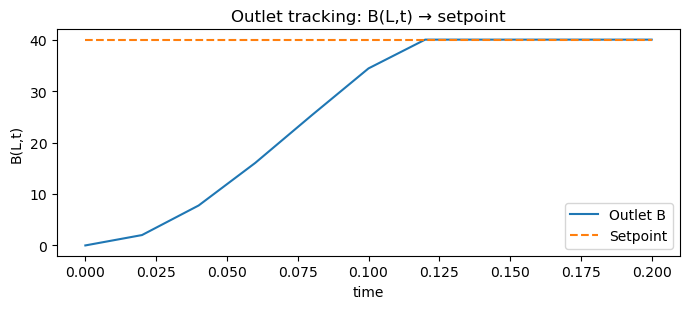

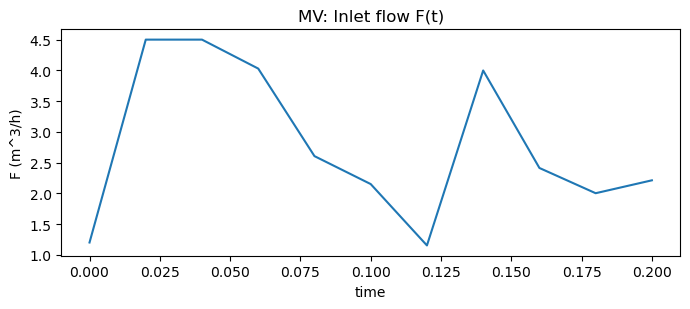

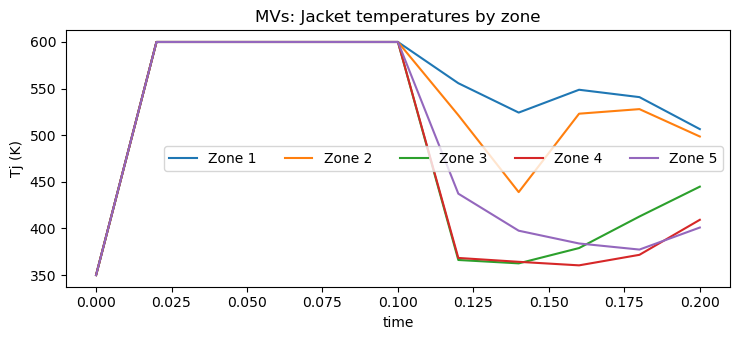

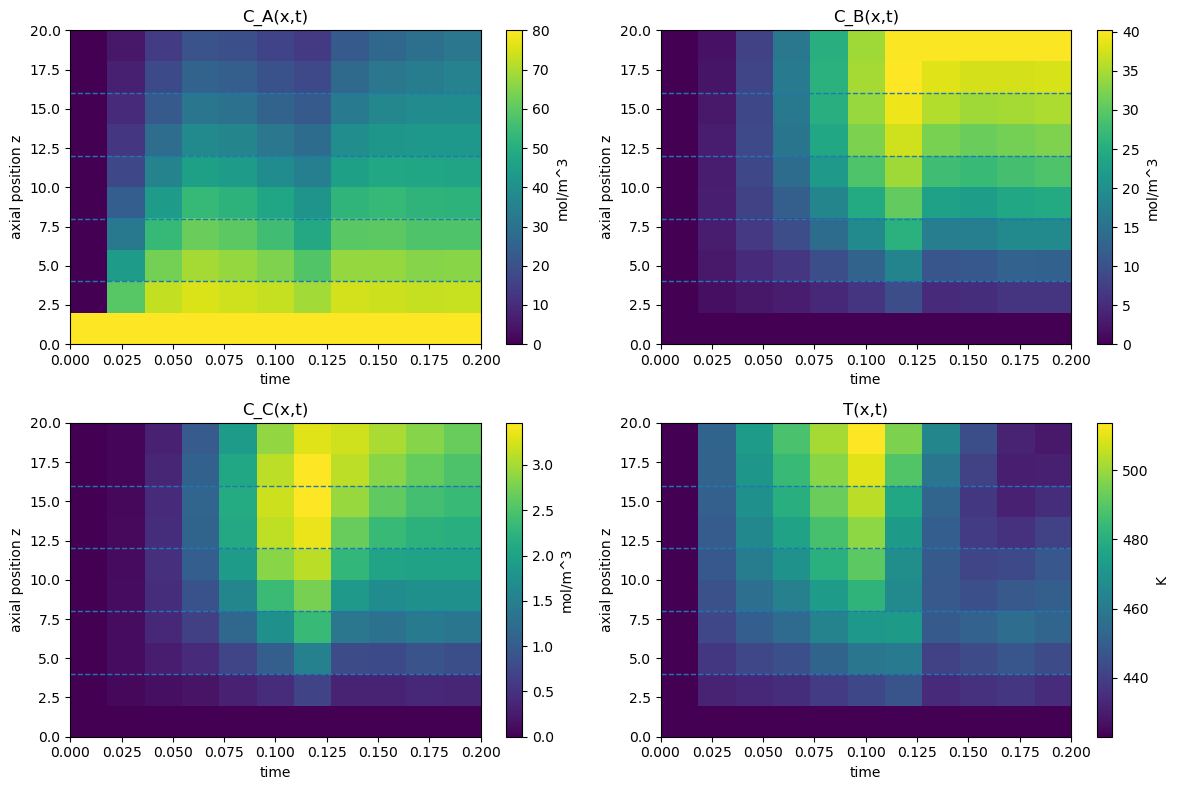

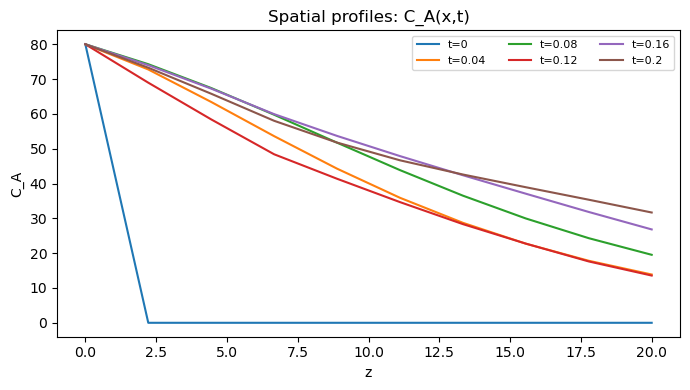

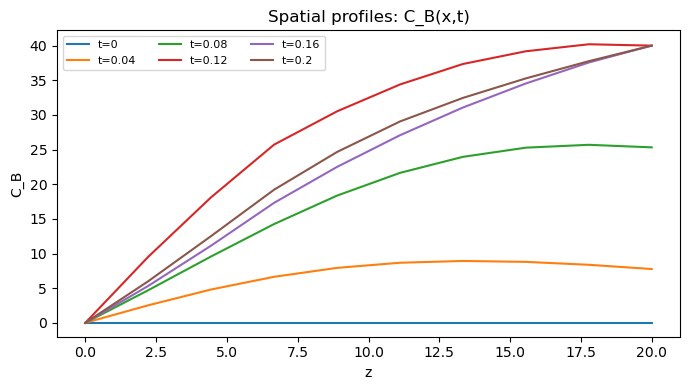

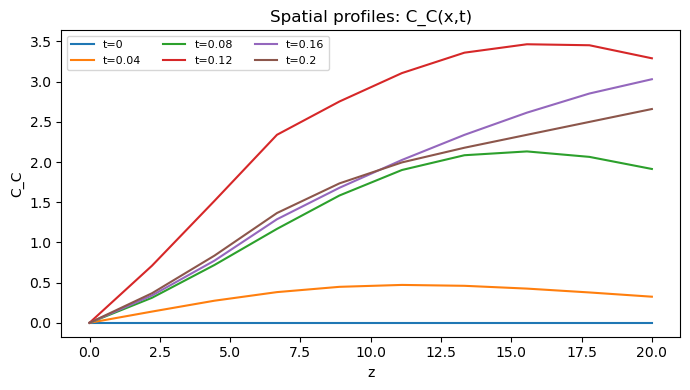

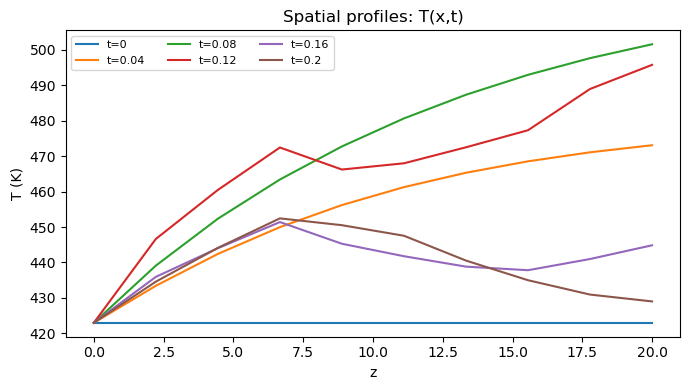

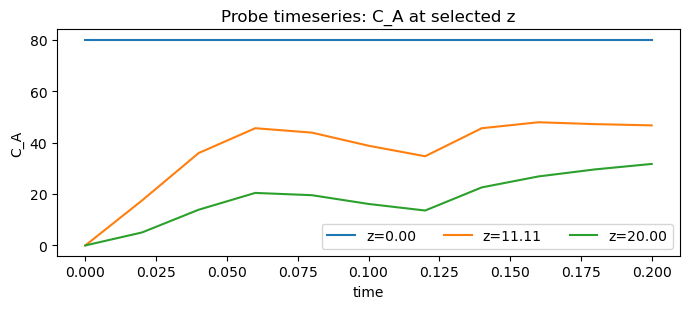

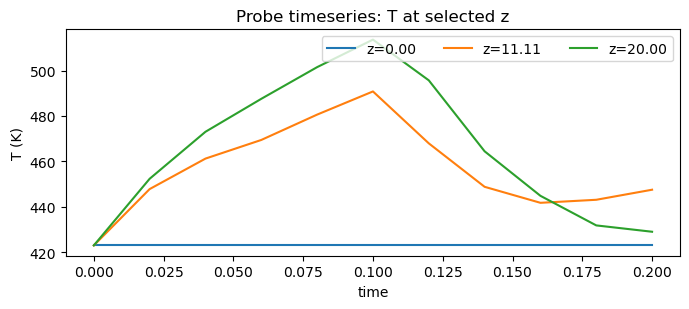

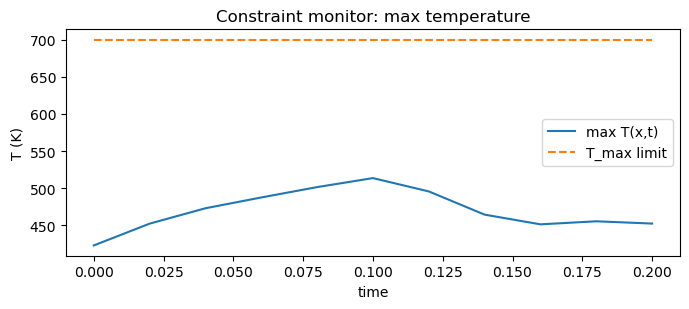

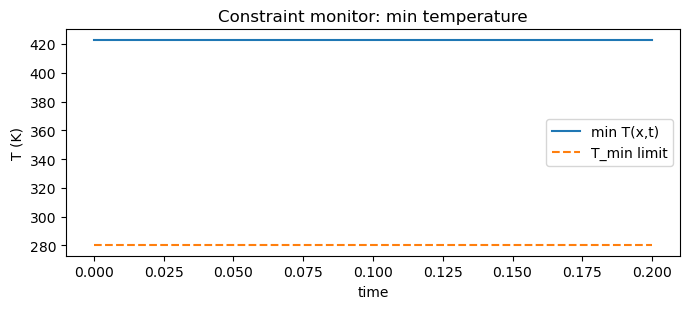

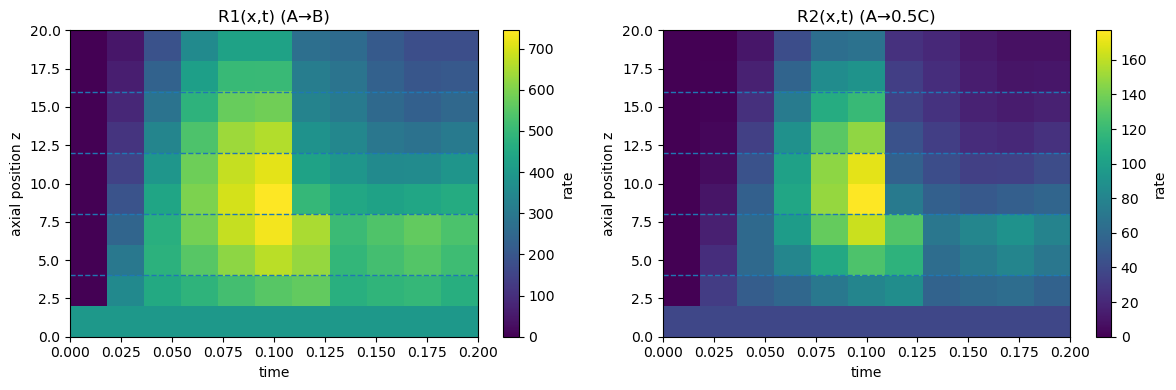

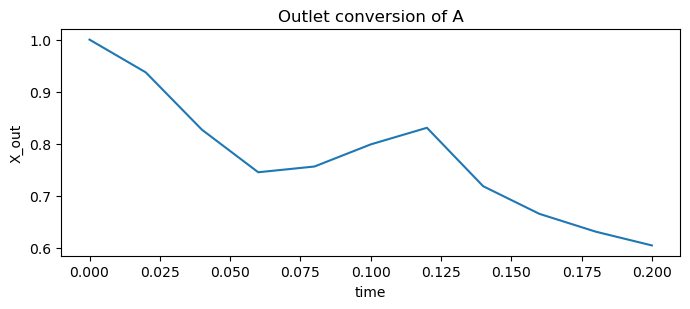

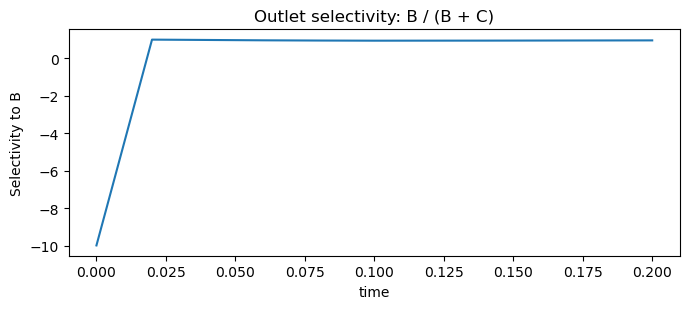

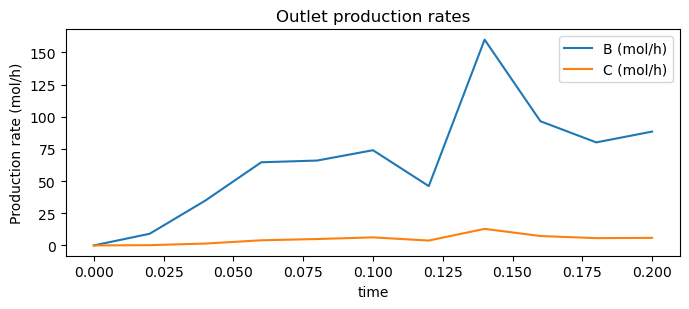

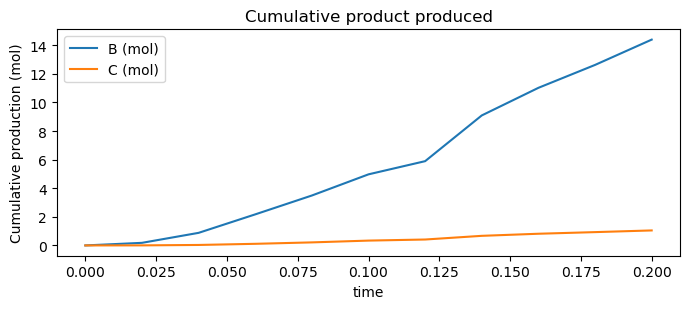

In [2]:
# ============================================================
# Plotting suite for the two-reaction, five-zone jacketed PFR
# Requires: numpy as np, matplotlib.pyplot as plt
# Inputs expected from your solve: z, t, cA, cB, cC, Tr, F, Tj, s, target_species, cA_in
# Optional: zone_bounds (array of length 6: [0, L/5, ..., L])
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# --- Kinetic constants (match the model you used) ---
Rgas  = 8.314
k01   = 0.1           # 1/h
E1    = 33475.0       # J/mol
k02   = 9.0e-7        # m^3/(mol*h)
E2    = 75319.0       # J/mol

def compute_reaction_rates(cA, Tr):
    """Return R1, R2 arrays with same shape as cA (N x K+1)."""
    R1 = k01 * np.exp((E1/Rgas) * (1.0/300.0 - 1.0/np.clip(Tr, 1e-6, None))) * cA
    R2 = k02 * np.exp((E2/Rgas) * (1.0/300.0 - 1.0/np.clip(Tr, 1e-6, None))) * (cA**2)
    return R1, R2

def _heatmap(ax, Z, t, z, title, label):
    im = ax.imshow(
        Z, origin="lower", aspect="auto",
        extent=(t[0], t[-1], z[0], z[-1])
    )
    ax.set_xlabel("time")
    ax.set_ylabel("axial position z")
    ax.set_title(title)
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(label)

def _overlay_zone_lines(ax, zone_bounds):
    if zone_bounds is None: 
        return
    for zb in zone_bounds[1:-1]:
        ax.axhline(zb, linestyle="--", linewidth=1)

def plot_setpoint_tracking(t, y_out, s, which="B_or_C"):
    plt.figure(figsize=(7,3.2))
    plt.plot(t, y_out, label=f"Outlet {which}")
    plt.plot(t, np.full_like(t, s), linestyle="--", label="Setpoint")
    plt.xlabel("time")
    plt.ylabel(f"{which}(L,t)")
    plt.title(f"Outlet tracking: {which}(L,t) → setpoint")
    plt.legend()
    plt.tight_layout()

def plot_MVs(t, F, Tj, zone_bounds=None):
    # Inlet flow
    plt.figure(figsize=(7,3.2))
    plt.plot(t, F)
    plt.xlabel("time")
    plt.ylabel("F (m^3/h)")
    plt.title("MV: Inlet flow F(t)")
    plt.tight_layout()

    # Jacket temps by zone
    n_zones = Tj.shape[0]
    plt.figure(figsize=(7.5, 3.5))
    for i in range(n_zones):
        plt.plot(t, Tj[i,:], label=f"Zone {i+1}")
    plt.xlabel("time")
    plt.ylabel("Tj (K)")
    plt.title("MVs: Jacket temperatures by zone")
    plt.legend(ncol=min(n_zones,5))
    plt.tight_layout()

def plot_space_time(z, t, cA, cB, cC, Tr, zone_bounds=None):
    fig, axes = plt.subplots(2, 2, figsize=(12,8))
    _heatmap(axes[0,0], cA, t, z, "C_A(x,t)", "mol/m^3")
    _overlay_zone_lines(axes[0,0], zone_bounds)

    _heatmap(axes[0,1], cB, t, z, "C_B(x,t)", "mol/m^3")
    _overlay_zone_lines(axes[0,1], zone_bounds)

    _heatmap(axes[1,0], cC, t, z, "C_C(x,t)", "mol/m^3")
    _overlay_zone_lines(axes[1,0], zone_bounds)

    _heatmap(axes[1,1], Tr, t, z, "T(x,t)", "K")
    _overlay_zone_lines(axes[1,1], zone_bounds)
    plt.tight_layout()

def plot_spatial_profiles(z, t, cA, cB, cC, Tr, times_to_show=6):
    idxs = np.unique(np.linspace(0, len(t)-1, times_to_show, dtype=int))
    # Concentrations
    plt.figure(figsize=(7,4))
    for k in idxs:
        plt.plot(z, cA[:,k], label=f"t={t[k]:.3g}")
    plt.xlabel("z"); plt.ylabel("C_A")
    plt.title("Spatial profiles: C_A(x,t)")
    plt.legend(ncol=3, fontsize=8); plt.tight_layout()

    plt.figure(figsize=(7,4))
    for k in idxs:
        plt.plot(z, cB[:,k], label=f"t={t[k]:.3g}")
    plt.xlabel("z"); plt.ylabel("C_B")
    plt.title("Spatial profiles: C_B(x,t)")
    plt.legend(ncol=3, fontsize=8); plt.tight_layout()

    plt.figure(figsize=(7,4))
    for k in idxs:
        plt.plot(z, cC[:,k], label=f"t={t[k]:.3g}")
    plt.xlabel("z"); plt.ylabel("C_C")
    plt.title("Spatial profiles: C_C(x,t)")
    plt.legend(ncol=3, fontsize=8); plt.tight_layout()

    # Temperature
    plt.figure(figsize=(7,4))
    for k in idxs:
        plt.plot(z, Tr[:,k], label=f"t={t[k]:.3g}")
    plt.xlabel("z"); plt.ylabel("T (K)")
    plt.title("Spatial profiles: T(x,t)")
    plt.legend(ncol=3, fontsize=8); plt.tight_layout()

def plot_probe_timeseries(z, t, cA, Tr, probes=("inlet","middle","outlet")):
    N = len(z)
    sel = []
    for p in probes:
        if p == "inlet": sel.append(0)
        elif p == "middle": sel.append(N//2)
        elif p == "outlet": sel.append(N-1)
        elif isinstance(p, (int,np.integer)): sel.append(p)
    sel = list(dict.fromkeys(sel))  # unique

    plt.figure(figsize=(7,3.2))
    for i in sel:
        plt.plot(t, cA[i,:], label=f"z={z[i]:.2f}")
    plt.xlabel("time"); plt.ylabel("C_A")
    plt.title("Probe timeseries: C_A at selected z")
    plt.legend(ncol=min(3,len(sel))); plt.tight_layout()

    plt.figure(figsize=(7,3.2))
    for i in sel:
        plt.plot(t, Tr[i,:], label=f"z={z[i]:.2f}")
    plt.xlabel("time"); plt.ylabel("T (K)")
    plt.title("Probe timeseries: T at selected z")
    plt.legend(ncol=min(3,len(sel))); plt.tight_layout()

def plot_constraints_monitoring(t, Tr, T_hi=700.0, T_lo=None):
    Tmax_t = Tr.max(axis=0)
    Tmin_t = Tr.min(axis=0)
    plt.figure(figsize=(7,3.2))
    plt.plot(t, Tmax_t, label="max T(x,t)")
    if T_hi is not None:
        plt.plot(t, np.full_like(t, T_hi), linestyle="--", label="T_max limit")
    plt.xlabel("time"); plt.ylabel("T (K)")
    plt.title("Constraint monitor: max temperature")
    plt.legend(); plt.tight_layout()

    plt.figure(figsize=(7,3.2))
    plt.plot(t, Tmin_t, label="min T(x,t)")
    if T_lo is not None:
        plt.plot(t, np.full_like(t, T_lo), linestyle="--", label="T_min limit")
    plt.xlabel("time"); plt.ylabel("T (K)")
    plt.title("Constraint monitor: min temperature")
    plt.legend(); plt.tight_layout()

def plot_reaction_rates(z, t, cA, Tr, zone_bounds=None):
    R1, R2 = compute_reaction_rates(cA, Tr)
    fig, axes = plt.subplots(1, 2, figsize=(12,4))
    _heatmap(axes[0], R1, t, z, "R1(x,t) (A→B)", "rate")
    _overlay_zone_lines(axes[0], zone_bounds)
    _heatmap(axes[1], R2, t, z, "R2(x,t) (A→0.5C)", "rate")
    _overlay_zone_lines(axes[1], zone_bounds)
    plt.tight_layout()

def plot_outlet_metrics(t, cA, cB, cC, F, cA_in):
    yB = cB[-1,:]; yC = cC[-1,:]; yA = cA[-1,:]
    eps = 1e-9
    X_out = 1.0 - yA/np.maximum(cA_in, eps)                               # conversion
    Sel_B = yB/np.maximum(yB + yC, eps)                                   # selectivity to B
    prodB_rate = F * yB                                                   # mol/h
    prodC_rate = F * yC
    cumB = np.cumsum(prodB_rate) * (t[1]-t[0])                            # mol
    cumC = np.cumsum(prodC_rate) * (t[1]-t[0])

    plt.figure(figsize=(7,3.2))
    plt.plot(t, X_out)
    plt.xlabel("time"); plt.ylabel("X_out")
    plt.title("Outlet conversion of A"); plt.tight_layout()

    plt.figure(figsize=(7,3.2))
    plt.plot(t, Sel_B)
    plt.xlabel("time"); plt.ylabel("Selectivity to B")
    plt.title("Outlet selectivity: B / (B + C)"); plt.tight_layout()

    plt.figure(figsize=(7,3.2))
    plt.plot(t, prodB_rate, label="B (mol/h)")
    plt.plot(t, prodC_rate, label="C (mol/h)")
    plt.xlabel("time"); plt.ylabel("Production rate (mol/h)")
    plt.title("Outlet production rates")
    plt.legend(); plt.tight_layout()

    plt.figure(figsize=(7,3.2))
    plt.plot(t, cumB, label="B (mol)")
    plt.plot(t, cumC, label="C (mol)")
    plt.xlabel("time"); plt.ylabel("Cumulative production (mol)")
    plt.title("Cumulative product produced")
    plt.legend(); plt.tight_layout()

def plot_all_pfr_results(z, t, cA, cB, cC, Tr, F, Tj, s, target_species, cA_in,
                         T_hi=700.0, T_lo=None, zone_bounds=None):
    """Call this once to generate the full figure set."""
    which = "B" if str(target_species).upper()=="B" else "C"
    y_out = cB[-1,:] if which=="B" else cC[-1,:]

    # 1) Outlet setpoint tracking
    plot_setpoint_tracking(t, y_out, s, which=f"{which}")

    # 2) Manipulated variables
    plot_MVs(t, F, Tj, zone_bounds=zone_bounds)

    # 3) Space-time heatmaps for cA, cB, cC, T
    plot_space_time(z, t, cA, cB, cC, Tr, zone_bounds=zone_bounds)

    # 4) Spatial profiles at selected times
    plot_spatial_profiles(z, t, cA, cB, cC, Tr, times_to_show=6)

    # 5) Probe time-series at inlet/middle/outlet
    plot_probe_timeseries(z, t, cA, Tr, probes=("inlet","middle","outlet"))

    # 6) Constraint monitoring
    plot_constraints_monitoring(t, Tr, T_hi=T_hi, T_lo=T_lo)

    # 7) Reaction rates heatmaps
    plot_reaction_rates(z, t, cA, Tr, zone_bounds=zone_bounds)

    # 8) Outlet conversion, selectivity, production
    plot_outlet_metrics(t, cA, cB, cC, F, cA_in)

# ============================================================
# Example call (run AFTER your solve populates arrays):
# ------------------------------------------------------------
plot_all_pfr_results(
    z=z, t=t, cA=cA, cB=cB, cC=cC, Tr=Tr,
    F=F, Tj=Tj, s=s, target_species=target_species,
    cA_in=cA_in, T_hi=700.0, T_lo=280.0,
    zone_bounds=zone_bounds  # from your model; or None
)
plt.show()
# ============================================================